In [56]:
# !pip install konlpy
# !pip install mecab-python
# !pip install mecab-python3
# !pip install unidic-lite

In [57]:
# !pip install scikit-learn

In [58]:
# !pip install transformersconda activate tf_env

In [59]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# 1) 데이터 로드하기

In [60]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x15034a020>)

In [61]:
total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])
print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력


전체 리뷰 개수 : 200000


In [62]:
total_data[:5]

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


# 2) 훈련 데이터와 테스트 데이터 분리하기

In [63]:
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)
total_data[:5]


,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


In [64]:
total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique()


(4, 199908, 2)

In [65]:
total_data.drop_duplicates(subset=['reviews'], inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(total_data))

총 샘플의 수 : 199908


In [66]:
print(total_data.isnull().values.any())

False


In [67]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 149931
테스트용 리뷰의 개수 : 49977


# 3) 레이블의 분포 확인

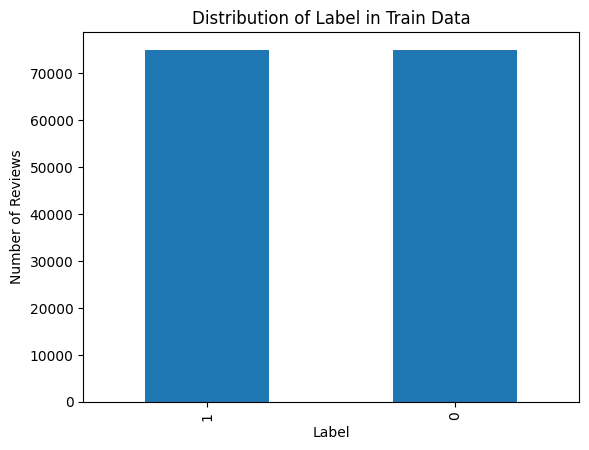

In [68]:
train_data['label'].value_counts().plot(kind = 'bar')

plt.title('Distribution of Label in Train Data')
plt.xlabel('Label')
plt.ylabel('Number of Reviews')
plt.show()

In [69]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  74918
1      1  75013


# 4) 데이터 정제하기

In [70]:
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

ratings    0
reviews    0
label      0
dtype: int64


/var/folders/hy/c34mqxh123lgnfptrbk38tjw0000gn/T/ipykernel_99808/482251640.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['reviews'].replace('', np.nan, inplace=True)


In [71]:
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True) # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 49977


/var/folders/hy/c34mqxh123lgnfptrbk38tjw0000gn/T/ipykernel_99808/3349398511.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경


# 5) 토큰화

In [72]:
mecab = Mecab()
print(mecab.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔'))


['와', '이런', '것', '도', '상품', '이', '라고', '차라리', '내', '가', '만드', '는', '게', '나을', '뻔']


In [73]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [74]:
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [75]:
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])


# 6) 단어와 길이 분포 확인하기

In [76]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)


In [77]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))


[(np.str_('네요'), 31802), (np.str_('는데'), 20197), (np.str_('안'), 19719), (np.str_('어요'), 14838), (np.str_('있'), 13200), (np.str_('너무'), 13057), (np.str_('했'), 11766), (np.str_('좋'), 9803), (np.str_('배송'), 9677), (np.str_('같'), 8997), (np.str_('어'), 8929), (np.str_('구매'), 8869), (np.str_('거'), 8861), (np.str_('없'), 8672), (np.str_('아요'), 8640), (np.str_('습니다'), 8436), (np.str_('그냥'), 8355), (np.str_('되'), 8345), (np.str_('잘'), 8029), (np.str_('않'), 7985)]


In [78]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))


[(np.str_('좋'), 39422), (np.str_('아요'), 21186), (np.str_('네요'), 19894), (np.str_('어요'), 18673), (np.str_('잘'), 18603), (np.str_('구매'), 16165), (np.str_('습니다'), 13320), (np.str_('있'), 12391), (np.str_('배송'), 12274), (np.str_('는데'), 11635), (np.str_('합니다'), 9801), (np.str_('했'), 9783), (np.str_('먹'), 9640), (np.str_('재'), 9274), (np.str_('너무'), 8398), (np.str_('같'), 7867), (np.str_('만족'), 7259), (np.str_('거'), 6484), (np.str_('어'), 6330), (np.str_('쓰'), 6291)]


긍정 리뷰의 평균 길이 : 13.57963286363697
부정 리뷰의 평균 길이 : 17.03147441202381


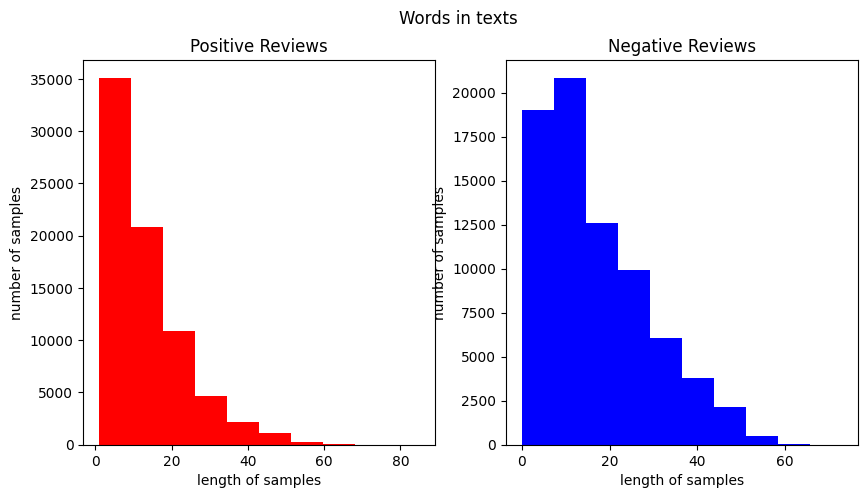

In [79]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()


In [80]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values


# 7) 정수 인코딩

In [81]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)


In [82]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


단어 집합(vocabulary)의 크기 : 40126
등장 빈도가 1번 이하인 희귀 단어의 수: 18274
단어 집합에서 희귀 단어의 비율: 45.54154413597169
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.7963870160240529


In [83]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)


단어 집합의 크기 : 21854


In [84]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [85]:
print(X_train[:3])

[[67, 2060, 300, 14295, 263, 73, 6, 237, 168, 136, 801, 2940, 626, 2, 76, 62, 207, 40, 1344, 155, 3, 6], [482, 400, 52, 8525, 2592, 2450, 338, 2941, 251, 2351, 39, 473, 2], [45, 24, 832, 104, 35, 2366, 160, 7, 10, 8058, 4, 1319, 30, 138, 323, 44, 59, 160, 138, 7, 1916, 2, 113, 163, 1385, 307, 119, 135]]


In [86]:
print(X_test[:3])

[[14, 704, 767, 115, 186, 252, 12], [338, 3907, 62, 3819, 1624], [11, 69, 2, 49, 164, 3, 27, 15, 6, 514, 289, 17, 92, 110, 584, 59, 7, 2]]


리뷰의 최대 길이 : 85
리뷰의 평균 길이 : 15.304460051623748


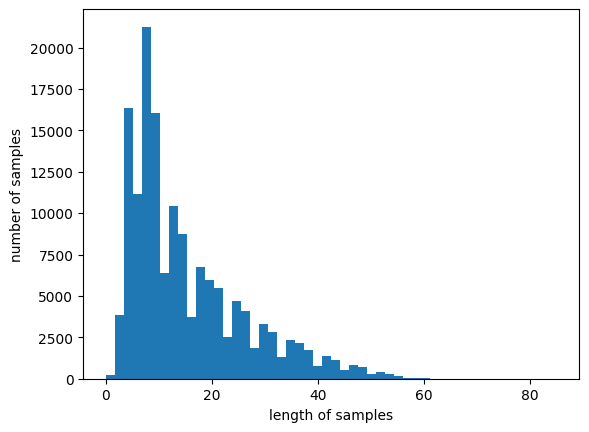

In [87]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [88]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))


In [89]:
max_len = 80
below_threshold_len(max_len, X_train)


전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.99933302652553


In [90]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)


In [91]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - acc: 0.8485 - loss: 0.3578
Epoch 1: val_acc improved from -inf to 0.91260, saving model to best_model.h5


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 146s 77ms/step - acc: 0.8486 - loss: 0.3578 - val_acc: 0.9126 - val_loss: 0.2463
Epoch 2/15
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - acc: 0.9165 - loss: 0.2328
Epoch 2: val_acc improved from 0.91260 to 0.91970, saving model to best_model.h5


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 148s 79ms/step - acc: 0.9165 - loss: 0.2327 - val_acc: 0.9197 - val_loss: 0.2229
Epoch 3/15
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - acc: 0.9272 - loss: 0.2067
Epoch 3: val_acc improved from 0.91970 to 0.92263, saving model to best_model.h5


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 148s 79ms/step - acc: 0.9272 - loss: 0.2067 - val_acc: 0.9226 - val_loss: 0.2147
Epoch 4/15
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - acc: 0.9343 - loss: 0.1895
Epoch 4: val_acc did not improve from 0.92263
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 139s 74ms/step - acc: 0.9343 - loss: 0.1895 - val_acc: 0.9218 - val_loss: 0.2203
Epoch 5/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - acc: 0.9377 - loss: 0.1787
Epoch 5: val_acc improved from 0.92263 to 0.92390, saving model to best_model.h5


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 148s 79ms/step - acc: 0.9377 - loss: 0.1787 - val_acc: 0.9239 - val_loss: 0.2115
Epoch 6/15
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - acc: 0.9442 - loss: 0.1638
Epoch 6: val_acc did not improve from 0.92390
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 139s 74ms/step - acc: 0.9442 - loss: 0.1638 - val_acc: 0.9234 - val_loss: 0.2125
Epoch 7/15
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - acc: 0.9458 - loss: 0.1600
Epoch 7: val_acc did not improve from 0.92390
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 143s 76ms/step - acc: 0.9458 - loss: 0.1600 - val_acc: 0.9224 - val_loss: 0.2182
Epoch 8/15
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - acc: 0.9518 - loss: 0.1452
Epoch 8: val_acc did not improve from 0.92390
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 167s 89ms/step - acc: 0.9518 - loss: 0.1452 - val_acc: 0.9204 - val_loss: 0.2235
Epoch 9/15
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - acc: 0.9544 - loss: 0.1375
Epoch 9: val_acc did not improve from 0.92390
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1

In [92]:
loaded_model = load_model('best_model.keras')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1562/1562 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - acc: 0.9230 - loss: 0.2166

 테스트 정확도: 0.9213


In [93]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)

  score = float(loaded_model.predict(pad_new))
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))


In [94]:
sentiment_predict('이 제품을 추천 합니다')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
68.27% 확률로 긍정 리뷰입니다.


/var/folders/hy/c34mqxh123lgnfptrbk38tjw0000gn/T/ipykernel_99808/276066950.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new))
